# Training Dataset Creation

In [1]:
import os
import sys
import pathlib

from PIL import Image
from PIL.Image import Resampling
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize, RandomHorizontalFlip, RandomRotation
import imagehash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.insert(0, '..')

## Walk through Train Directory

In [2]:
paths = []

for (dirpath, dirnames, filenames) in os.walk('../data/Training Data'):
    for filename in filenames:
        extension = pathlib.Path(filename).suffix
        if extension == '.jpg':
            path = os.path.join(dirpath, filename)
            path = os.path.normcase(path)
            paths.append(path)
            print(path)

..\data\training data\backyard\seattle_3269390_1.jpg
..\data\training data\backyard\seattle_3269390_2.jpg
..\data\training data\backyard\seattle_3269390_3.jpg
..\data\training data\backyard\seattle_6362362_1.jpg
..\data\training data\backyard\seattle_6362362_2.jpg
..\data\training data\backyard\seattle_6424982_1.jpg
..\data\training data\backyard\seattle_6424982_2.jpg
..\data\training data\basement\seattle_9550869_1.jpg
..\data\training data\basement\seattle_9550869_2.jpg
..\data\training data\bathroom\boston_15543904_1.jpg
..\data\training data\bathroom\boston_15543904_2.jpg
..\data\training data\bathroom\boston_15843621_2.jpg
..\data\training data\bathroom\boston_1584362_1.jpg
..\data\training data\bathroom\boston_16559025_1.jpg
..\data\training data\bathroom\boston_16559025_2.jpg
..\data\training data\bathroom\boston_1696090_1.jpg
..\data\training data\bathroom\boston_1696090_2.jpg
..\data\training data\bathroom\boston_1783990_1.jpg
..\data\training data\bathroom\boston_1783990_2.jp

In [3]:
os.path.basename('..\data\training data\kitchen\seattle_5680462_4.jpg')

'seattle_5680462_4.jpg'

## Functions that Determine Label

In [4]:
def is_duplicate(path_1, path_2):
    filename_1_parts = os.path.basename(path_1).split('_')
    filename_2_parts = os.path.basename(path_2).split('_')
    # {city}_{roomid}_{match number}.jpg
    return filename_1_parts[0] == filename_2_parts[0] and filename_1_parts[1] == filename_2_parts[1]

def get_class(path_1, path_2):
    return int(is_duplicate(path_1, path_2))

In [5]:
assert is_duplicate('..\data\training data\kitchen\seattle_5680462_1.jpg', '..\data\training data\kitchen\seattle_5680462_2.jpg')

## Training Dataset Creation (Pandas)

In [6]:
def create_training_dataset(paths):
    image1s = []
    image2s = []
    classes = []
    for path1 in paths:
        for path2 in paths:
            image1s.append(path1)
            image2s.append(path2)
            classes.append(get_class(path1, path2))
    return pd.DataFrame({
        'image1': image1s,
        'image2': image2s,
        'class': classes
    })

In [7]:
train_df = create_training_dataset(paths)
train_df.shape

(398161, 3)

In [8]:
train_df.sample(20)

,image1,image2,class
384390,..\data\training data\living-room\seattle_5680...,..\data\training data\bedroom\boston_223015090...,0
105244,..\data\training data\bedroom\boston_4558227_2...,..\data\training data\living-room\boston_28542...,0
310148,..\data\training data\living-room\boston_26157...,..\data\training data\kitchen\boston_1315879_1...,0
194259,..\data\training data\house-exterior\boston_91...,..\data\training data\living-room\boston_56618...,0
169942,..\data\training data\dining-room\seattle_2481...,..\data\training data\bedroom\boston_8955630_2...,0
397641,..\data\training data\tv-room\seattle_3308979_...,..\data\training data\bedroom\boston_223015090...,0
146767,..\data\training data\bedroom\seattle_6424982_...,..\data\training data\kitchen\boston_4349688_1...,0
384432,..\data\training data\living-room\seattle_5680...,..\data\training data\bedroom\boston_39369319_...,0
115400,..\data\training data\bedroom\boston_5661892_5...,..\data\training data\living-room\boston_66879...,0
100695,..\data\training data\bedroom\boston_43814611_...,..\data\training data\kitchen\boston_2530537_3...,0


In [9]:
train_df['class'].value_counts()

0    394396
1      3765
Name: class, dtype: int64

## Upsampling Duplicate Pairs

- Add horizontal flip flag to duplicate image pairs
- Permutate horizonal flip flags for each image pair (1, 0), (0, 1) and (1, 1)

Number of duplicate pairs will increase 4x to 15,060 (3765 * 4)

In [10]:
train_df['img1_hflip'] = 0
train_df['img2_hflip'] = 0

In [11]:
duplicate_pairs_df = train_df.loc[train_df['class'] == 1].copy()
duplicate_pairs_df.shape

(3765, 5)

In [12]:
upsampled_df = pd.DataFrame()
        
for img1_hflip in [True, False]:
    for img2_hflip in [True, False]:
        temp_df = duplicate_pairs_df.copy()
        temp_df['img1_hflip'] = img1_hflip
        temp_df['img2_hflip'] = img2_hflip
        upsampled_df = pd.concat([upsampled_df, temp_df], ignore_index=True)

In [13]:
upsampled_df.loc[:, ['img1_hflip', 'img2_hflip']].drop_duplicates()

,img1_hflip,img2_hflip
0,True,True
3765,True,False
7530,False,True
11295,False,False


In [14]:
upsampled_df['class'].shape

(15060,)

## Downsampling Non-Duplicate Pairs

- Compute perceptual hash
- Find threshold and filter pairs that are similar

In [15]:
image_hash_dict = dict()

for path in paths:
    image = Image.open(path)
    image = image.resize((256, 256), resample=Resampling.BILINEAR)
    image_hash_dict[path] = imagehash.whash(image)
    
len(image_hash_dict)

631

In [16]:
def compute_similarity(img1_path, img2_path):
    return image_hash_dict[img1_path] - image_hash_dict[img2_path]

In [17]:
non_duplicate_pairs_df = train_df.loc[train_df['class'] == 0].copy()
non_duplicate_pairs_df.shape

(394396, 5)

<Axes: ylabel='Frequency'>

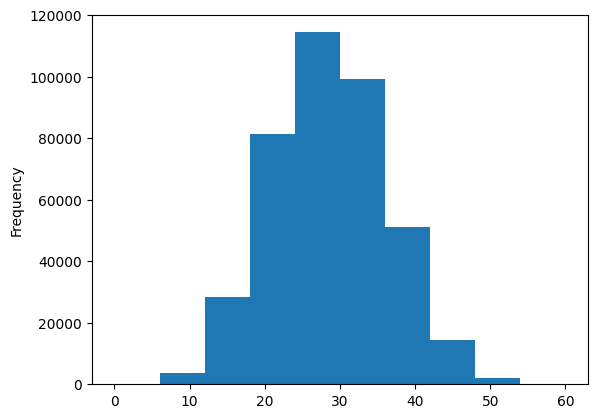

In [18]:
non_duplicate_pairs_df['similarity'] = non_duplicate_pairs_df.apply(lambda row: compute_similarity(row['image1'], 
                                                                                                   row['image2']), 
                                                                    axis=1)
non_duplicate_pairs_df['similarity'].plot(kind='hist')

In [19]:
non_duplicate_pairs_df[non_duplicate_pairs_df['similarity'] <= 10]

,image1,image2,class,img1_hflip,img2_hflip,similarity
644,..\data\training data\backyard\seattle_3269390...,..\data\training data\bathroom\boston_16559025...,0,0,0,10
802,..\data\training data\backyard\seattle_3269390...,..\data\training data\bedroom\boston_503659_2.jpg,0,0,0,10
831,..\data\training data\backyard\seattle_3269390...,..\data\training data\bedroom\boston_8686077_1...,0,0,0,10
832,..\data\training data\backyard\seattle_3269390...,..\data\training data\bedroom\boston_8686077_2...,0,0,0,10
893,..\data\training data\backyard\seattle_3269390...,..\data\training data\dining-room\seattle_1110...,0,0,0,8
...,...,...,...,...,...,...
395838,..\data\training data\staircase\seattle_955086...,..\data\training data\bedroom\boston_8686077_2...,0,0,0,10
396030,..\data\training data\staircase\seattle_955086...,..\data\training data\kitchen\boston_8955630_1...,0,0,0,10
396131,..\data\training data\staircase\seattle_955086...,..\data\training data\living-room\boston_28276...,0,0,0,10
396134,..\data\training data\staircase\seattle_955086...,..\data\training data\living-room\boston_28542...,0,0,0,10


In [20]:
non_duplicate_pairs_df.loc[644, 'image1'], non_duplicate_pairs_df.loc[644, 'image2']

('..\\data\\training data\\backyard\\seattle_3269390_2.jpg',
 '..\\data\\training data\\bathroom\\boston_16559025_1.jpg')

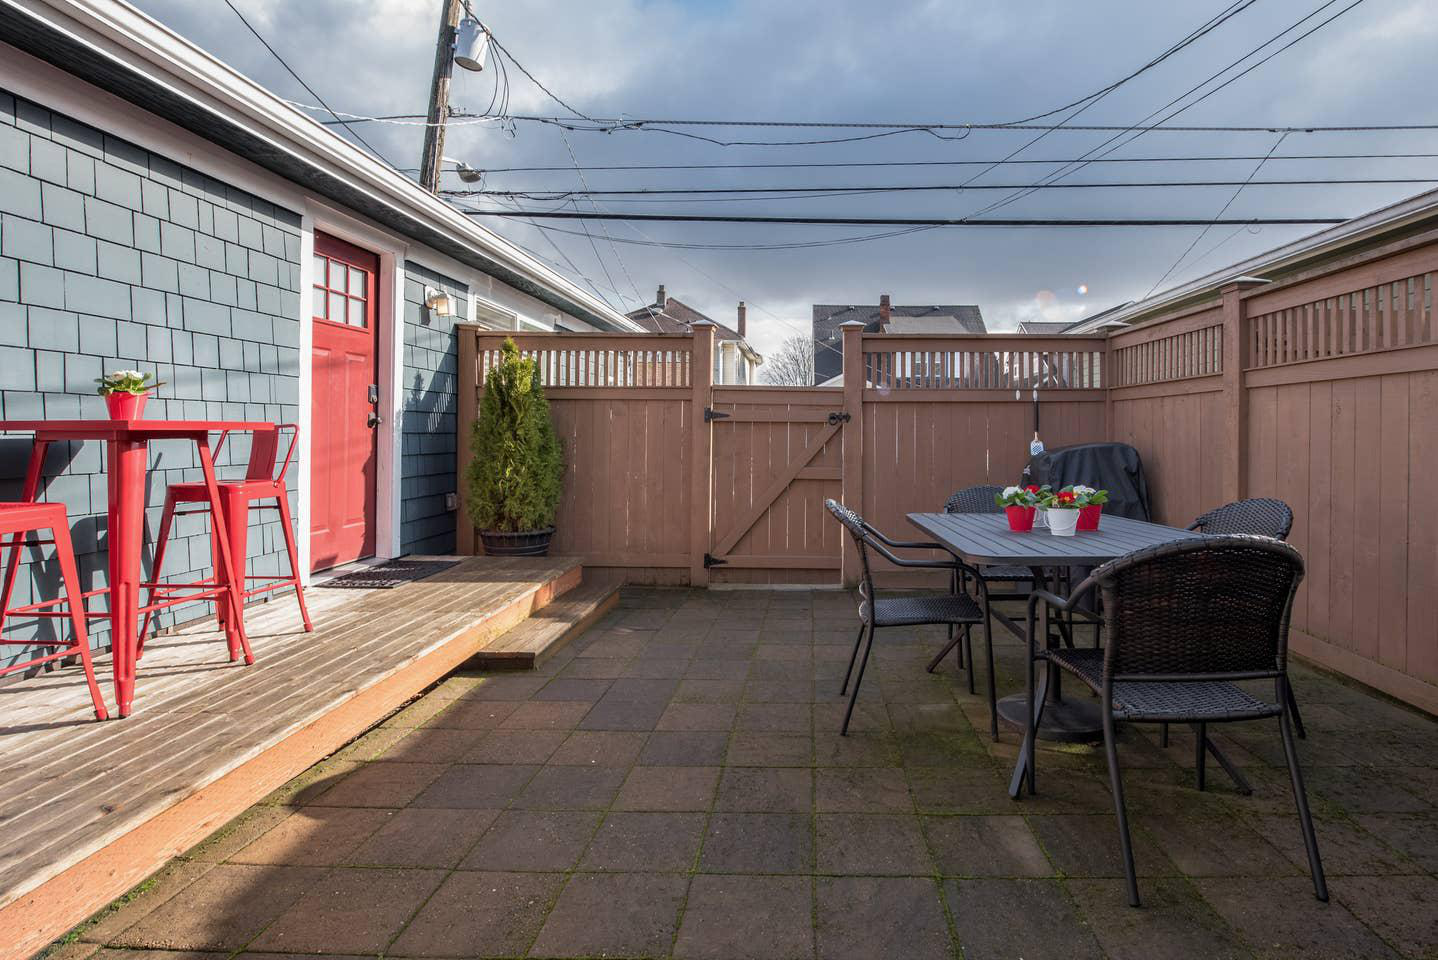

In [21]:
Image.open('..\\data\\training data\\backyard\\seattle_3269390_2.jpg')

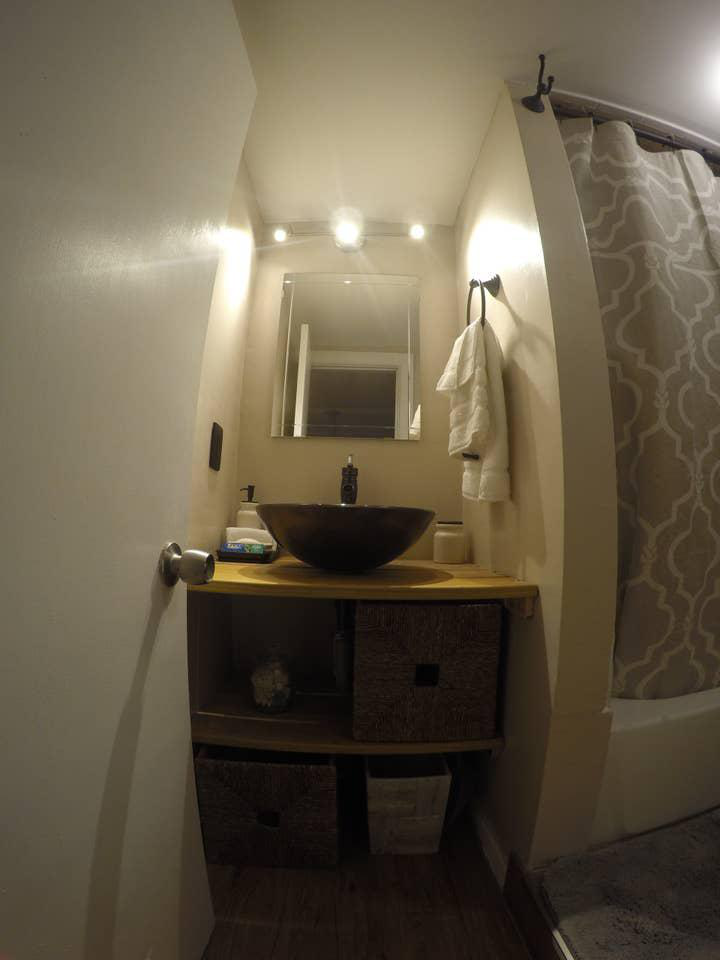

In [22]:
Image.open('..\\data\\training data\\bathroom\\boston_16559025_1.jpg')

<Axes: ylabel='Frequency'>

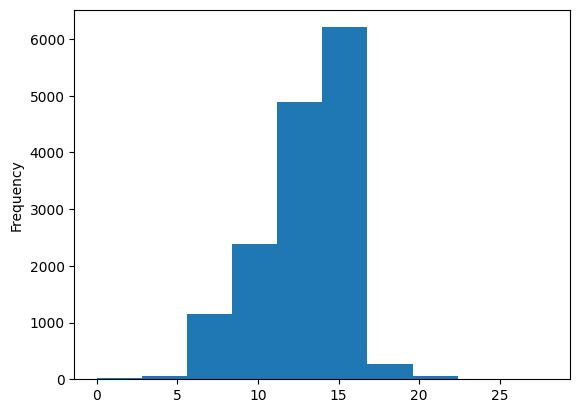

In [23]:
non_duplicate_pairs_df['sampling_weight'] = 1 / np.exp(non_duplicate_pairs_df['similarity'])
non_duplicate_pairs_df = non_duplicate_pairs_df.sample(15060, weights=non_duplicate_pairs_df['sampling_weight'], random_state=0)
non_duplicate_pairs_df['similarity'].plot(kind='hist')

## Finalise Training Dataset

In [24]:
train_df = pd.concat([upsampled_df, non_duplicate_pairs_df], ignore_index=True).drop(['similarity'], axis=1)
train_df.head()

,image1,image2,class,img1_hflip,img2_hflip,sampling_weight
0,..\data\training data\backyard\seattle_3269390...,..\data\training data\backyard\seattle_3269390...,1,1,1,NaN
1,..\data\training data\backyard\seattle_3269390...,..\data\training data\backyard\seattle_3269390...,1,1,1,NaN
2,..\data\training data\backyard\seattle_3269390...,..\data\training data\backyard\seattle_3269390...,1,1,1,NaN
3,..\data\training data\backyard\seattle_3269390...,..\data\training data\house-exterior\seattle_3...,1,1,1,NaN
4,..\data\training data\backyard\seattle_3269390...,..\data\training data\house-exterior\seattle_3...,1,1,1,NaN


In [25]:
train_df.sample(10)

,image1,image2,class,img1_hflip,img2_hflip,sampling_weight
5600,..\data\training data\house-exterior\boston_43...,..\data\training data\house-exterior\boston_43...,1,1,0,NaN
7915,..\data\training data\bedroom\boston_13724244_...,..\data\training data\kitchen\boston_13724244_...,1,0,1,NaN
26766,..\data\training data\house-exterior\boston_47...,..\data\training data\kitchen\seattle_8515408_...,0,0,0,6.144212e-06
27404,..\data\training data\living-room\boston_40341...,..\data\training data\living-room\boston_28542...,0,0,0,8.315287e-07
9728,..\data\training data\kitchen\boston_4090224_1...,..\data\training data\kitchen\boston_4090224_1...,1,0,1,NaN
4491,..\data\training data\bedroom\boston_26157205_...,..\data\training data\bedroom\boston_26157205_...,1,1,0,NaN
29216,..\data\training data\living-room\boston_44614...,..\data\training data\kitchen\boston_120494_1.jpg,0,0,0,1.125352e-07
10700,..\data\training data\living-room\boston_57246...,..\data\training data\living-room\boston_57246...,1,0,1,NaN
24854,..\data\training data\bedroom\boston_1321422_2...,..\data\training data\dining-room\seattle_3883...,0,0,0,8.315287e-07
16058,..\data\training data\living-room\boston_26157...,..\data\training data\bedroom\boston_8686077_1...,0,0,0,4.539993e-05


## Import `DuplicateImageDataset` Class and Compare

- Above code is ported to `DuplicateImageDataset` that inherits from `torch.utils.data.Dataset`

In [26]:
from scripts.dataset_duplicate_image import DuplicateImageDataset

In [27]:
dataset = DuplicateImageDataset('../data/Training Data', 
                                upsample_transforms_dict={
                                    'hflip': RandomHorizontalFlip(p=1)
                                })

In [28]:
len(train_df)

30120

In [29]:
assert len(dataset) == len(train_df)

In [30]:
dataset = DuplicateImageDataset('../data/Training Data', balance_classes=False)
assert len(dataset) == (len(paths) ** 2)

In [31]:
dataset[100000]

(tensor([[[0.7922, 0.8118, 0.8235,  ..., 0.8588, 0.8627, 0.8745],
          [0.8039, 0.8196, 0.8275,  ..., 0.8549, 0.8627, 0.8706],
          [0.8118, 0.8196, 0.8275,  ..., 0.8549, 0.8588, 0.8706],
          ...,
          [0.8000, 0.7961, 0.7922,  ..., 0.8431, 0.7882, 0.8039],
          [0.8000, 0.7961, 0.7922,  ..., 0.8588, 0.8000, 0.7961],
          [0.7882, 0.7882, 0.7843,  ..., 0.8627, 0.8000, 0.7725]],
 
         [[0.7569, 0.7765, 0.7882,  ..., 0.8902, 0.8980, 0.8980],
          [0.7686, 0.7843, 0.7922,  ..., 0.8863, 0.8980, 0.8941],
          [0.7765, 0.7843, 0.7922,  ..., 0.8863, 0.8941, 0.8941],
          ...,
          [0.6549, 0.6510, 0.6471,  ..., 0.8902, 0.8353, 0.8510],
          [0.6549, 0.6510, 0.6471,  ..., 0.9059, 0.8471, 0.8431],
          [0.6510, 0.6431, 0.6392,  ..., 0.9098, 0.8471, 0.8196]],
 
         [[0.7216, 0.7412, 0.7529,  ..., 0.8980, 0.8941, 0.8980],
          [0.7333, 0.7490, 0.7569,  ..., 0.8941, 0.8941, 0.8941],
          [0.7412, 0.7490, 0.7569,  ...,

## Wrap `DuplicateImageDataset` in DataLoader

In [32]:
dataset = DuplicateImageDataset('../data/Training Data', transforms=[Resize((256, 256))])
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

7530


In [33]:
train_img_1s, train_img_2s, train_labels = next(iter(dataloader))
print('Image 1s shape:', train_img_1s.size())
print('Image 2s shape:', train_img_2s.size())
print('Labels shape:', train_labels.size())

Image 1s shape: torch.Size([64, 3, 256, 256])
Image 2s shape: torch.Size([64, 3, 256, 256])
Labels shape: torch.Size([64])


## Test Multiple Transforms in `DuplicateImageDataset`

In [34]:
dataset = DuplicateImageDataset('../data/Training Data', 
                                upsample_transforms_dict={
                                    'hflip': RandomHorizontalFlip(p=1),
                                    'anticlockwise_rot': RandomRotation((5, 5), expand=True),
                                    'clockwise_rot': RandomRotation((-5, -5), expand=True)
                                })

In [35]:
assert(len(dataset) == 3765 * 2 ** (3 * 2) * 2)